In [1]:
import os
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import talib
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from pathlib import Path

In [2]:
# choose your output directory
path = r'C:\SCRIPT\TA'

print('Stock Ticker: ')
# =============================================================================
Stock = input().upper()
# =============================================================================
print('Days of Analysis: ')
# =============================================================================
DoA = int(input())
# =============================================================================

Stock Ticker: 
eni.mi
Days of Analysis: 
550


In [3]:
try :
    StockNAME,MARKET = Stock.split('.', 1)
except ValueError:
    StockNAME = Stock

path_output = path + '/'+ StockNAME
Path(path_output).mkdir(parents=True, exist_ok=True)
os.chdir(path_output)

current_time = datetime.now()
minuti , ore, day, month, year = current_time.minute, current_time.hour, current_time.day, current_time.month, current_time.year

# Get today's date as UTC timestamp
today = datetime.today().strftime("%d/%m/%Y")
today = datetime.strptime(today + " +0000", "%d/%m/%Y %z")
to = int(today.timestamp())
# Get date ten years ago as UTC timestamp
ten_yr_ago = today-relativedelta(years=10)
fro = int(ten_yr_ago.timestamp())

In [4]:
def get_price_hist(ticker):

    # Put stock price data in dataframe
    url = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={fro}&period2={to}&interval=1d&events=history".format(ticker=ticker, fro=fro, to=to)
    data = pd.read_csv(url)    
    # Convert date to timestamp and make index
    data.index = data["Date"].apply(lambda x: pd.Timestamp(x))
    data.drop("Date", axis=1, inplace=True)

    return data

In [5]:
df_Stock = get_price_hist(Stock)
df_Stock.dropna(how='all', inplace=True)

In [6]:

def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['Close'])
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["Close"], timeperiod=10)
    data["ma30"] = talib.MA(data["Close"], timeperiod=30)
    # Get RSI
    data["rsi"] = talib.RSI(data["Close"])
    
    return data

In [7]:

df_Stock = get_indicators(df_Stock)

In [8]:

def plot_chart(data, n, ticker):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.fill_between(data.index, y1= 30, y2=70, color='#adccff', alpha=0.3)
    ax_rsi.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000000)
    ax_vol.set_ylabel("(Million)")
   
    # Save the chart as PNG
    fig.savefig(StockNAME + '_' + str(year)+ '_' +str(month)+ '_' +str(day)+ '_' +str(ore)+ '_' + str(minuti) + ".png", bbox_inches="tight")
    
    plt.show()

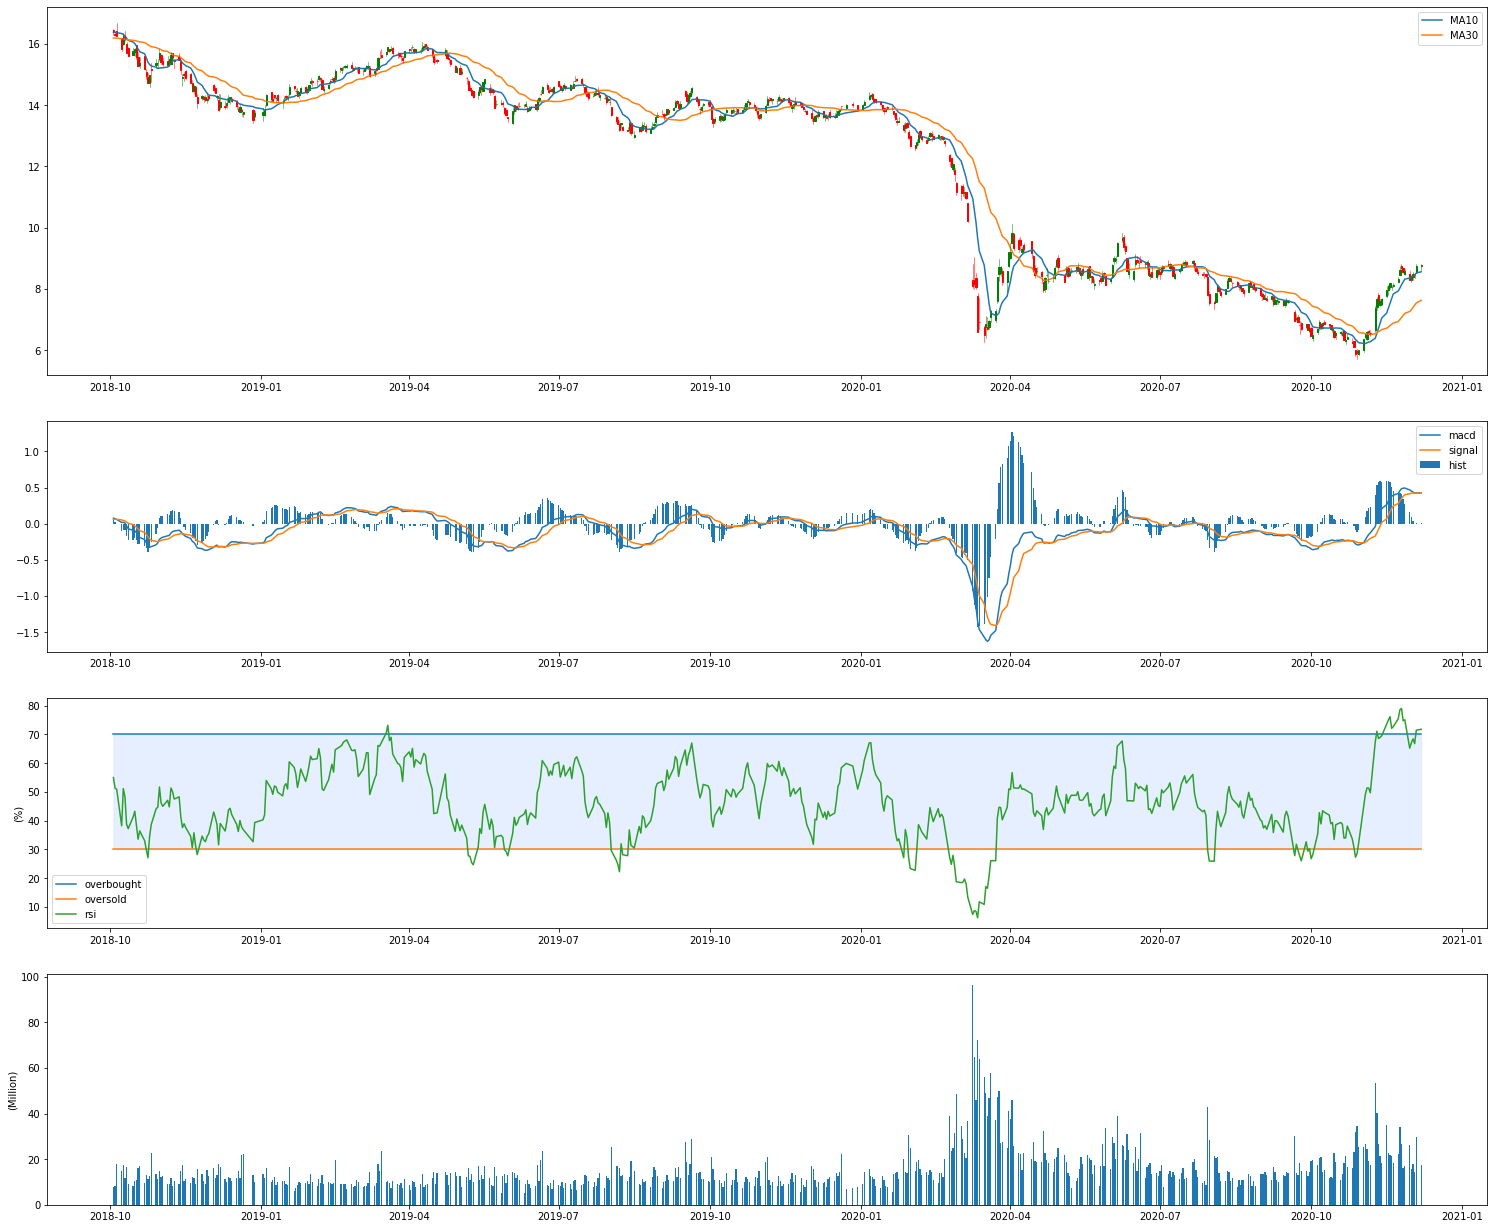

In [9]:
plot_chart(df_Stock, DoA, Stock)